In [1]:
%cd /Users/gwg/dmcm

/Users/gwg/dmcm


In [ ]:
import numpy as np
import torch
import random
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from   PIL import Image

from   data import GTExV8Config, GTExV8Dataset, loader
from   models import DCGANAE128, DPCCA

In [ ]:
%matplotlib inline

In [ ]:
cfg = GTExV8Config()

directory = '/Users/gwg/dmcm/experiments/20190131_big_sweep/'\
            'gtexv8_mode-dpcca_batch_size-128_seed-0_latent_dim-10_lr-0.0001_l1_coef-0.5_em_iters-1_clip-1'

In [ ]:
print(cfg.IMG_SIZE)
train_loader, test_loader = loader.get_data_loaders(cfg,
                                                    batch_size=128,
                                                    num_workers=1,
                                                    pin_memory=False,
                                                    directory=directory)
dataset = GTExV8Dataset(cfg)

128


In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
all_tissues = dataset.tissues_df.values.squeeze()
le.fit(all_tissues)
tissue_nums = le.transform(all_tissues)

In [8]:
inds = test_loader.sampler.indices
n    = len(inds)

X1 = torch.Tensor(n, cfg.N_CHANNELS, cfg.IMG_SIZE, cfg.IMG_SIZE)
X2 = torch.Tensor(n, cfg.N_GENES)
labels = torch.Tensor(n)
tissues = []

for j, i in enumerate(inds):
    x1, x2 = dataset[i]
    X1[j] = x1
    X2[j] = x2
    labels[j] = float(tissue_nums[i])
    tissues.append(all_tissues[i])

tissues = np.array(tissues)

In [146]:

# directory = '/Users/gwg/dmcm/experiments/20190205_decaying_l1/'\
#             'gtexv8_mode-dpcca_batch_size-128_seed-0_latent_dim-20_lr-0.0001_l1_coef-1.5_em_iters-1_clip-1'
  
state = torch.load(directory + '/model.pt', map_location={'cuda:0': 'cpu'})
model = DPCCA(cfg, latent_dim=10)
model.load_state_dict(state)

Zs = model.estimate_z_given_x([X1, X2], threshold=None)
print(X1.shape)
print(X2.shape)
print(Zs.shape)

torch.Size([1179, 3, 128, 128])
torch.Size([1179, 39832])
torch.Size([1179, 30])


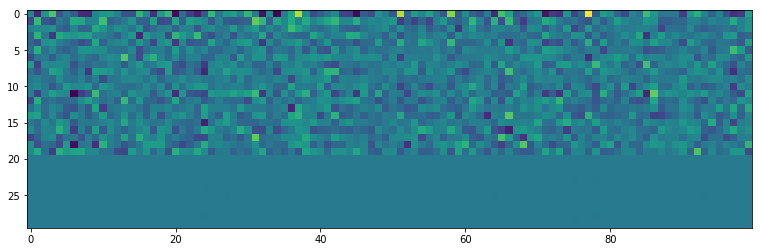

In [151]:
Zs = Zs.detach()
Zs.shape

fig, ax = plt.subplots(figsize=(22, 4))
ZSs = Zs#[:, :10]
ax.imshow(ZSs[:100].t())

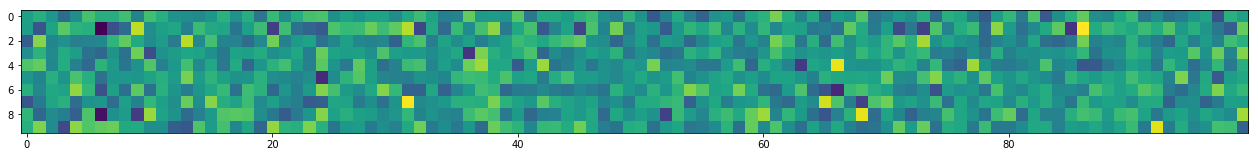

In [148]:
Z1s = Zs[:, 10:20]
fig, ax = plt.subplots(figsize=(22, 4))
ax.imshow(Z1s[:100].t(), interpolation='nearest')

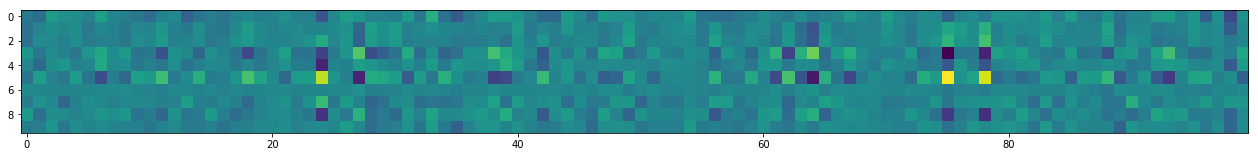

In [149]:
Z2s = Zs[:, 20:]
fig, ax = plt.subplots(figsize=(22, 4))
ax.imshow(Z2s[:100].t(), interpolation='nearest')

In [152]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

<class 'torch.Tensor'>


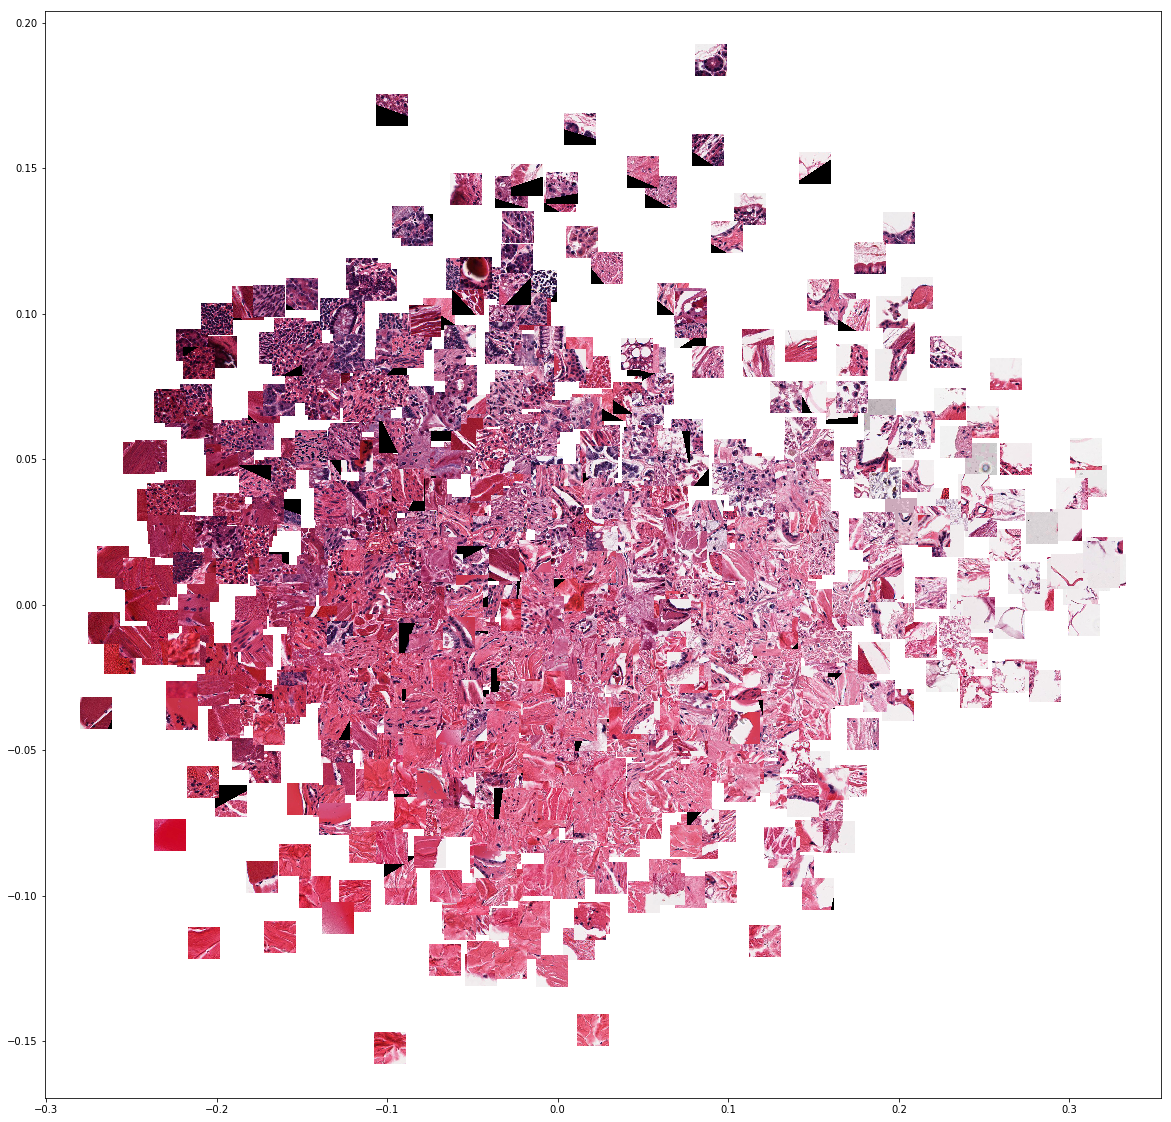

In [153]:
from sklearn.decomposition import PCA

decompressor = PCA(n_components=2)
Zs_pca = decompressor.fit_transform(Zs[:, :10])

fig, ax = plt.subplots(figsize=(20, 20))

print(type(X1))

for i in np.unique(labels):
    inds = labels.numpy() == i
    for img, data in zip(X1.numpy()[inds], Zs_pca[inds]):
        imscatter(data[0], data[1], img.T, ax, zoom=0.25)

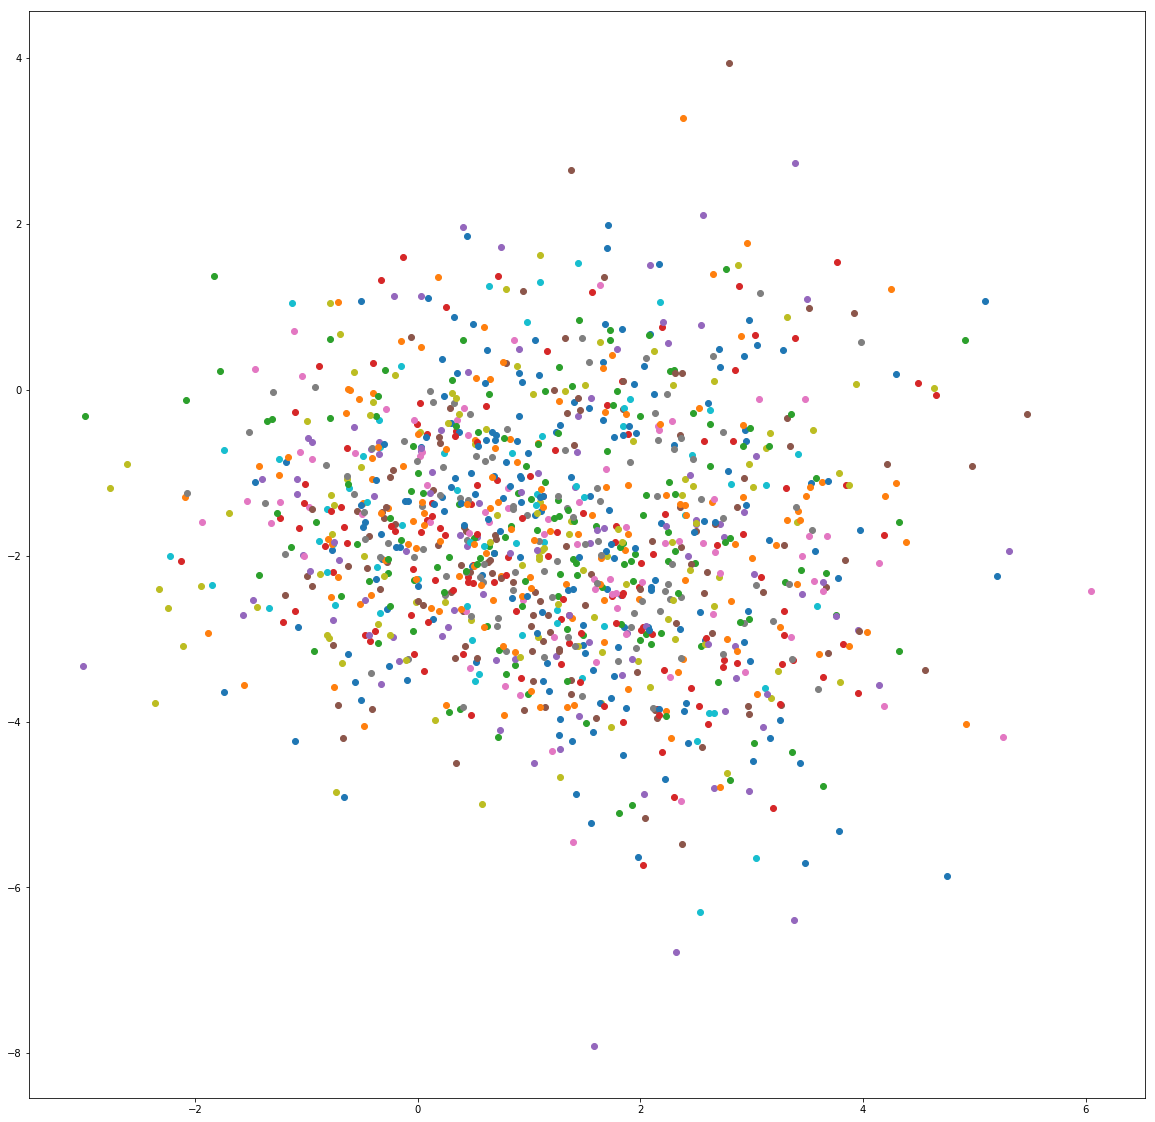

In [154]:
# ne1 = model.image_net.encode(X1)
ne2 = model.genes_net.encode(X2).detach().numpy()

# ne2_pca = decompressor.fit_transform(ne2)
fig, ax = plt.subplots(figsize=(20, 20))

for i in np.unique(labels):
    inds = labels.numpy() == i
    data = ne2[inds]
    ax.scatter(data[:, 6], data[:, 4], label=i)

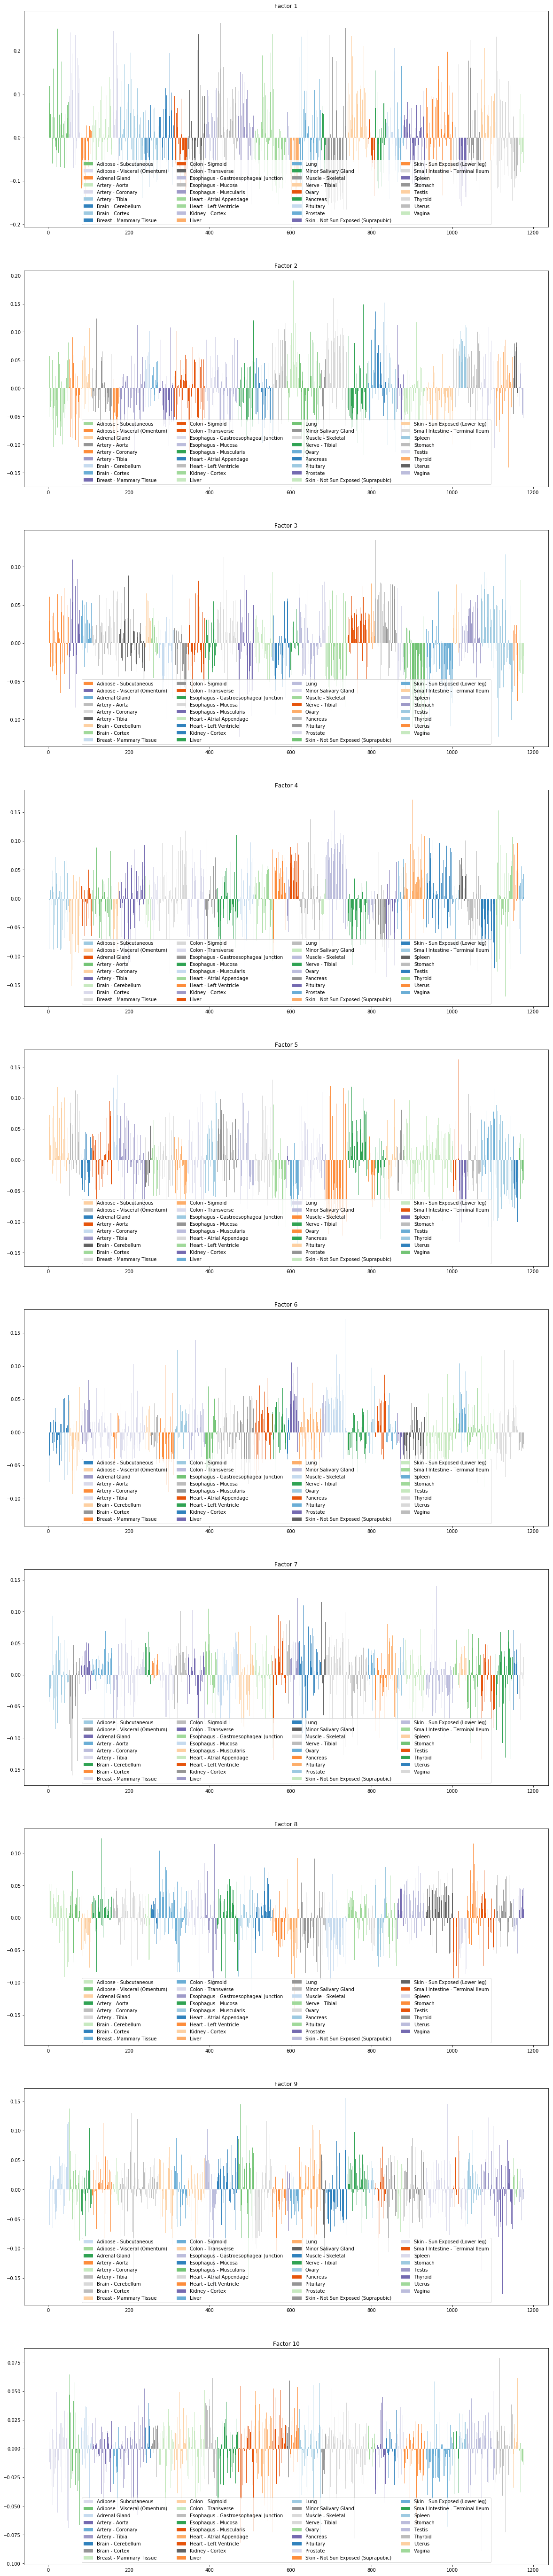

In [156]:
fig, axes = plt.subplots(10, 1)
fig.set_size_inches(20, 100)

for ax, factor_idx in zip(axes.flat, range(0, 10)):

    inds          = np.argsort(labels)
    labels_sorted = labels[inds].numpy()
    tiss_sorted   = tissues[inds]
    Zs_sorted     = Zs.numpy()[inds]
    zk            = Zs_sorted[:, factor_idx]

    cm = plt.cm.get_cmap('tab20c', len(np.unique(labels)))
    colors = cm.colors
    np.random.shuffle(colors)  # inplace

    curr_label = labels_sorted[0]
    j = 0
    curr_color = colors[j]

    labels_added = []

    for i, z in enumerate(Zs_sorted):
        if curr_label != labels_sorted[i]:
            curr_label = labels_sorted[i]
            j += 1
            curr_color = cm.colors[j]

        curr_tiss = tiss_sorted[i]
        if curr_tiss not in labels_added:
            labels_added.append(curr_tiss)
            ax.bar(i, zk[i], color=curr_color, label=curr_tiss)
        else:
            ax.bar(i, zk[i], color=curr_color)

    ax.set_title('Factor %s' % str(factor_idx+1))
    ax.legend(ncol=4, loc='lower center')

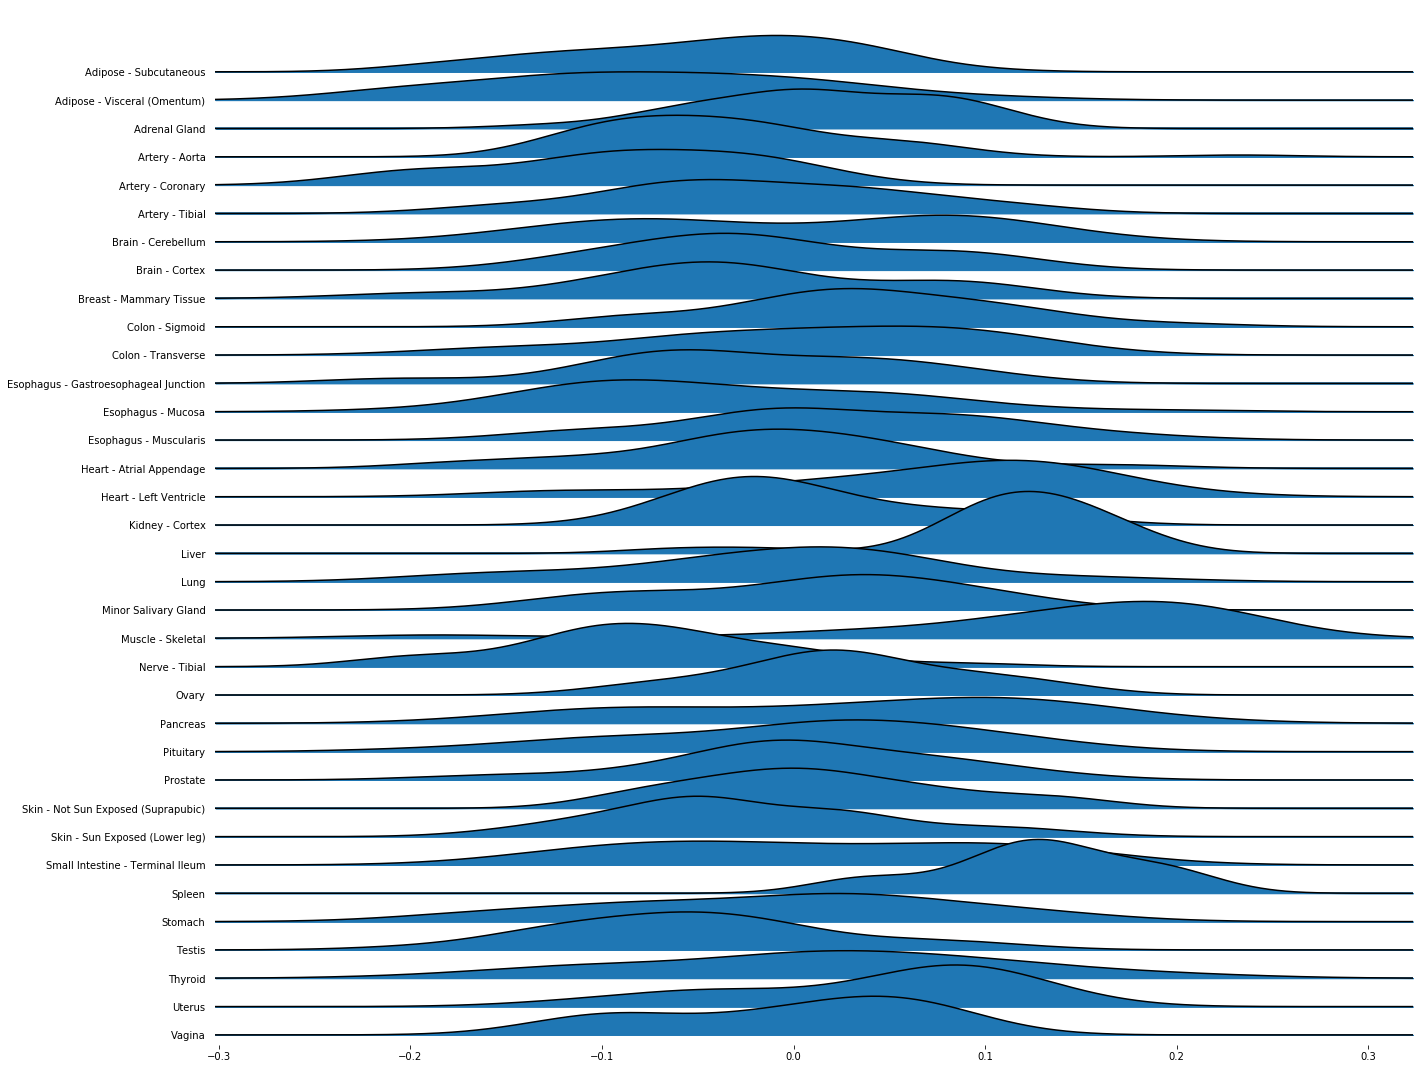

In [15]:
import pandas as pd
import joypy

cm = plt.cm.get_cmap('tab20c', len(np.unique(labels)))

df = pd.DataFrame()
for i in np.unique(labels_sorted):
    tiss = le.inverse_transform([int(i)])[0]
    data = Zs_sorted[labels_sorted == i][:, factor_idx]
    df_new = pd.DataFrame({
        tiss: data.tolist()
    })
    df = pd.concat([df, df_new], axis=1)

fig, axes = joypy.joyplot(df, figsize=(20, 15))

In [16]:
# tissue_name = 'Muscle - Skeletal'
tissue_name = 'Nerve - Tibial'

index = None
for i in np.unique(labels):
    tiss = le.inverse_transform([int(i)])[0]
    if tiss == tissue_name:
        index = float(i)
        break

inds = labels.numpy() == index
images_one_type  = X1.numpy()[inds]
tissues_one_type = tissues[inds]
Zs_one_type      = Zs.numpy()[inds]

pos_inds = Zs_one_type[:, factor_idx] > 0
neg_inds = Zs_one_type[:, factor_idx] < 0

pos_ = Zs_one_type[:, factor_idx][pos_inds]
neg_ = Zs_one_type[:, factor_idx][neg_inds]

# pos = np.where(Zs_one_type[:, factor_idx] > pos_.mean())[0]
# neg = np.where(Zs_one_type[:, factor_idx] < neg_.mean())[0]

pos = np.where(Zs_one_type[:, factor_idx] > 0)[0]
neg = np.where(Zs_one_type[:, factor_idx] < 0)[0]

max_samples = 30
pos = pos[:max_samples]
neg = neg[:max_samples]

print(pos)
print(neg)

[ 2 14 18 21 25 33 46]
[ 0  1  3  4  5  6  7  8  9 10 11 12 13 15 16 17 19 20 22 23 24 26 27 28
 29 30 31 32 34 35]


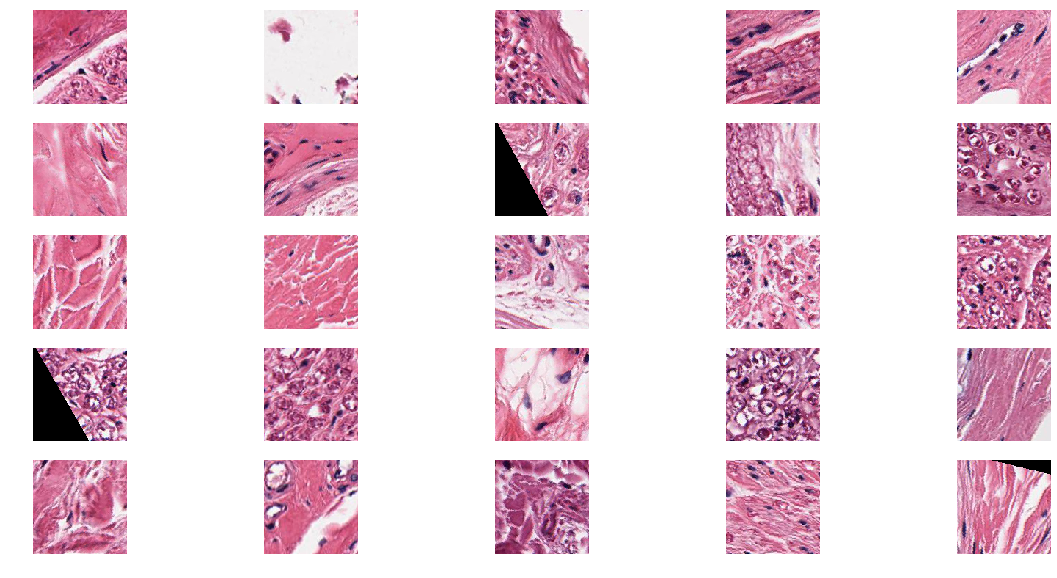

In [15]:
import math

n_cols = 5
n_rows = math.ceil(len(pos) / n_cols)

f, axarr = plt.subplots(n_rows, n_cols)
f.set_size_inches(20, 10)

k = 0
for ax in axarr.flat:
    ax.imshow(images_one_type[pos[k]].T)
    ax.axis('off')
    k += 1
    if k == len(pos):
        break

5


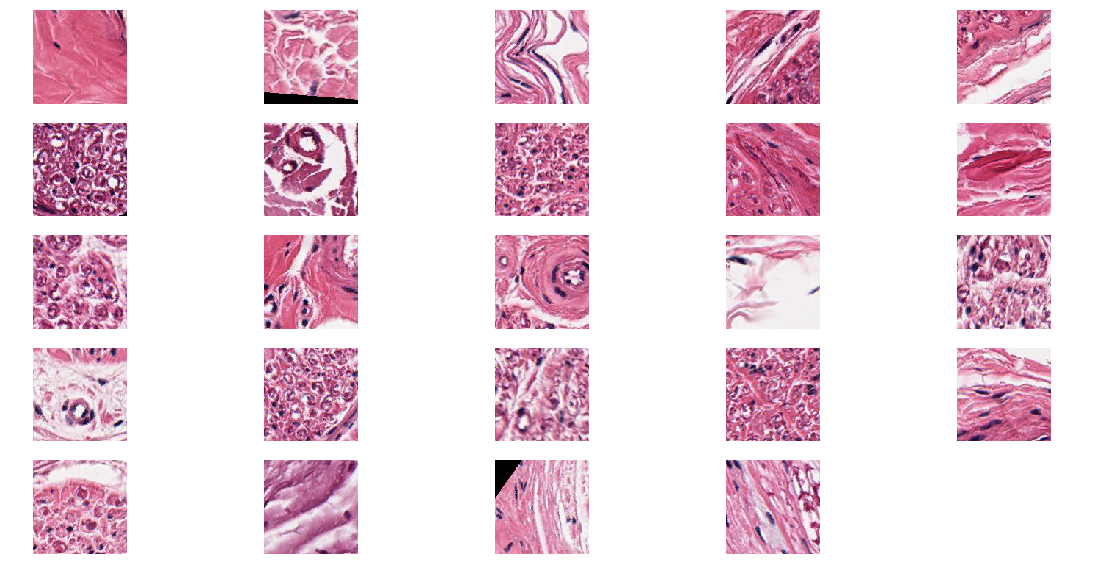

In [16]:
n_cols = 5
n_rows = math.ceil(len(neg) / n_cols)
print(n_rows)

f, axarr = plt.subplots(n_rows, n_cols)
f.set_size_inches(20, 10)
plt.axis('off')

k = 0
for ax in axarr.flat:
    ax.imshow(images_one_type[neg[k]].T)
    ax.axis('off')
    k += 1
    if k == len(neg):
        break

(49, 60)


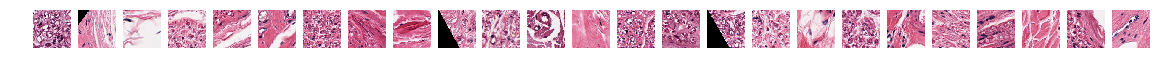

In [18]:
index = None
for i in np.unique(labels):
    tiss = le.inverse_transform([int(i)])[0]
    if tiss == tissue_name:
        index = float(i)
        break

inds = labels.numpy() == index
images_one_type  = X1.numpy()[inds]
Zs_one_type      = Zs.numpy()[inds]

print(Zs_one_type.shape)

for factor_idx in [0]:#range(10, 20):
    inds = np.argsort(Zs_one_type[:, factor_idx])
    
    indices = list(range(0, len(inds), 2))
    f, axarr = plt.subplots(1, len(indices))
    f.set_size_inches(20, 10)
    plt.axis('off')

    for ax, i in zip(axarr.flat, indices):
        ax.imshow(images_one_type[inds][i].T)
        ax.axis('off')

In [136]:
genes_one_type = X2.numpy()[inds]
Zs_one_type    = Zs.numpy()[inds]
inds = np.argsort(Zs_one_type[:, factor_idx])
indices = list(range(0, len(inds), 1))

gene_symbols = np.array(dataset.genes_df.index.tolist())

for ax, i in zip(axarr.flat, indices):
    genes = genes_one_type[inds][i]
    with open('/Users/gwg/Desktop/genelists/%s.txt' % i, 'w+') as f:
        msg = ['%s,%s' % (s, g) for s, g in zip(gene_symbols, genes)]
        msg = '\n'.join(msg)
        f.write(msg)